In [2]:
%pylab --no-import-all inline
import skimage.io, skimage.measure, skimage.morphology, skimage.transform

Populating the interactive namespace from numpy and matplotlib


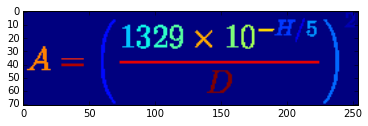

In [3]:
image = skimage.io.imread('enwiki-equation-images/5.png', flatten=True) / 255.0

label_image = skimage.measure.label(image)
labels = label_image * (image!=1)
pyplot.imshow(labels)

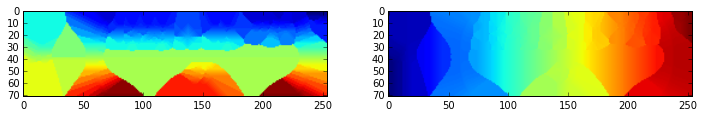

In [14]:
import scipy.ndimage
# for this point, which (x/y) is nearest?
dist_ys, dist_xs = scipy.ndimage.distance_transform_edt(
    image==1,
    return_indices=True,
    return_distances=False,
)

pyplot.figure(figsize=(12,3))
ax1 = pyplot.subplot(1,2,1)
ax1.imshow(dist_ys)
ax1 = pyplot.subplot(1,2,2)
ax1.imshow(dist_xs)

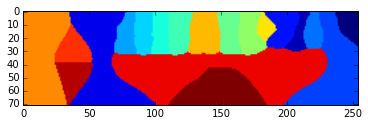

In [6]:
# For this point, which label is the nearest?
h, w = image.shape
im = np.array([[labels[dist_ys[y,x],dist_xs[y,x]] for x in range(w)] for y in range(h)])
pyplot.imshow(im)

# Adjacency matrix

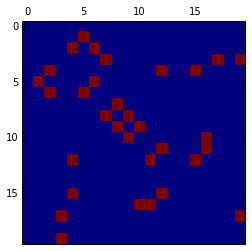

In [45]:
from collections import defaultdict
adj = defaultdict(lambda: defaultdict(int))

for x in range(w-1):
    for y in range(h-1):
        here = im[y,x]
        under = im[y+1,x]
        if here != under:
            adj[here][under] = 1
        right = im[y,x+1]
        if here != right:
            adj[here][right] = 1

n = len(np.unique(labels))
adjm = np.array([[adj[i][j] for j in range(n)] for i in range(n)])
pyplot.matshow(adjm)

# Graph representation
Each node consists of components.

In [36]:
regions = [None]
for region in skimage.measure.regionprops(label_image, 1-image):
    if np.any(region.intensity_image * region.image):
        regions.append( region )

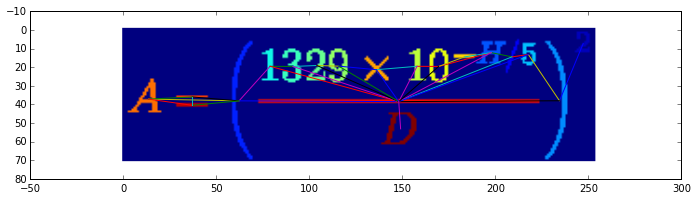

In [88]:
# draw adjacency graph
import itertools
from matplotlib.lines import Line2D
nodes = [set([i]) for i in np.unique(labels)[1:]]

def show_graph(ax, nodes):
    node_image = sum(sum(labels==ni for ni in n)*(i+1) for i,n in enumerate(nodes))
    ax.imshow(node_image)
    for a,b in itertools.combinations(nodes, 2):
        if sum(adj[ai][bi] for (ai,bi) in itertools.product(a,b)):
            ra = skimage.measure.regionprops(sum(labels==ai for ai in a))[0]
            rb = skimage.measure.regionprops(sum(labels==bi for bi in b))[0]
            ray, rax = ra.centroid
            rby, rbx = rb.centroid
            ax.plot([rax,rbx], [ray,rby])

pyplot.figure(figsize=(12,3))
ax = pyplot.axes()
show_graph(ax, nodes)

Some kind of transitions:
Every move is a classification.

    push [A]
    move to [-]
    merge with [-]
    move to [(]
    move to [----]
    move to [1]: double push
    move to [3]
    move to [2]
    move to [9]
    move to [x]
    move to [1]
    move to [0]
    move to [-]: push
    move to [H]
    move to [/]
    move to [5]
    pop & classify?
    pop
    move to [D]
    pop
    move to [)]
    move to [2]: push
    pop & classify
    pop
    

# Merge labels

 - Node: Merge the regions, extract scaled bounding box
 - Edge: Re-calculate all edge features

In [41]:
def get_scaled_bbox(buff, region, scale=4.0):
    t, l, b, r = region.bbox
    h_, w_ = region.local_centroid
    off = scale / max(h_,w_)
    minr = buff-off - w_ + t
    minc = buff-off - h_ + l
    maxr = buff+off + w_ + b
    maxc = buff+off + h_ + r
    return minr, minc, maxr, maxc

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


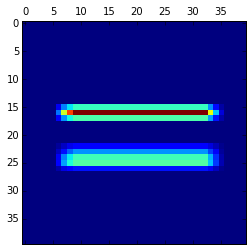

In [59]:
buff = max(image.shape)/2
padded = np.pad(1-image, buff, mode='minimum')
region = skimage.measure.regionprops( (labels==21) + (labels==19) )[0]
minr, minc, maxr, maxc = get_scaled_bbox(buff, region)
part = skimage.transform.resize(padded[minr:maxr, minc:maxc], (40,40))
pyplot.matshow( part )